In [11]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# from jupyterthemes import jtplot
# jtplot.style()

In [12]:
import os
import gc
import cv2
import time
import random
import shutil
import itertools
import sklearn

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from keras import backend as K
from matplotlib import pyplot as plt

from glob import glob
from tqdm import tqdm
from itertools import cycle
from tabulate import tabulate
from pandas import DataFrame
from keras import regularizers, optimizers, initializers

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from keras.models import Sequential, Model
from keras.layers.core import Dense
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator

from keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
)
from sklearn.metrics import (
    roc_curve, auc, multilabel_confusion_matrix, ConfusionMatrixDisplay, classification_report, confusion_matrix
)
from tensorflow.keras.applications import (
    VGG16, VGG19, InceptionV3, Xception, DenseNet121, ResNet50V2, MobileNet, MobileNetV2, EfficientNetB0, EfficientNetB1, 
    EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7, 
    NASNetMobile, NASNetLarge
)

In [13]:
def plot_class_samples(samples_count):
    labels = list(samples_count.keys())
    count = list(samples_count.values())
    
    plt.rcParams['figure.dpi'] = 150
    fig, ax = plt.subplots(figsize =(18, 8))
    ax.barh(labels, count)
    
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 2)
    ax.yaxis.set_tick_params(pad = 3)
    
    # Add x, y gridlines
    ax.grid(visible = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
    
    # Show top values
    ax.invert_yaxis()
    
    # Add annotation to bars
    for i in ax.patches:
        plt.text(
            i.get_width() + 0.2, 
            i.get_y() + 0.5, 
            str(round((i.get_width()), 2)), 
            fontsize = 10, 
            fontweight = 'bold', 
            color ='grey'
        )
    
    ax.set_title('Samples Belonging to Each Class Label', loc ='center')
    plt.show()

In [17]:
# Set the path to the directory containing the images
data_dir = './Mutually_Exclusive_Images'

# Set the percentage of images to use for training, validation, and testing
train_percent = 0.75
val_percent = 0.15
test_percent = 0.1

# Get the list of subdirectories (i.e., class names) in the data directory
subdirs = [name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name))]

# For each subdirectory, create corresponding subdirectories in the train, validation, and test directories
train_dir = './divided_data/train'
val_dir = './divided_data/val'
test_dir = './divided_data/test'

In [18]:
for subdir in subdirs:
    os.makedirs(os.path.join(train_dir, subdir))
    os.makedirs(os.path.join(val_dir, subdir))
    os.makedirs(os.path.join(test_dir, subdir))

    # Get the list of image filenames in the subdirectory
    filenames = os.listdir(os.path.join(data_dir, subdir))

    # Shuffle the filenames
    random.shuffle(filenames)

    # Compute the number of images to use for training, validation, and testing
    num_train = int(len(filenames) * train_percent)
    num_val = int(len(filenames) * val_percent)
    num_test = int(len(filenames) * test_percent)

    # Copy the first num_train images to the train directory
    for filename in filenames[ : num_train]:
        src = os.path.join(data_dir, subdir, filename)
        dst = os.path.join(train_dir, subdir, filename)
        shutil.copyfile(src, dst)

    # Copy the next num_val images to the validation directory
    for filename in filenames[num_train : num_train + num_val]:
        src = os.path.join(data_dir, subdir, filename)
        dst = os.path.join(val_dir, subdir, filename)
        shutil.copyfile(src, dst)

    # Copy the last num_test images to the test directory
    for filename in filenames[num_train + num_val : num_train + num_val + num_test]:
        src = os.path.join(data_dir, subdir, filename)
        dst = os.path.join(test_dir, subdir, filename)
        shutil.copyfile(src, dst)

In [41]:
CLASS_LABELS = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", 
    "Infiltration", "Mass", "No Finding", "Nodule", "Pleural_Thickening", "Pneumonia","Pneumothorax"
]

# CLASS_LABELS = [
#     "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", 
#     "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"
# ]

USE_TRANSFER_LEARNING = True
IMAGE_SIZE = (224, 224,)
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 0.0001 if USE_TRANSFER_LEARNING else 0.01

BETA_FOR_BIASED_RECALL = 1.3
BETA_FOR_BIASED_PRECISION = 0.7
BETA_WITH_NO_BIAS = 1

THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [42]:
def apply_sharpening(image):
    sharp_kernel = np.array(
        [
            [0, -1, 0], 
            [-1, 5, -1], 
            [0, -1, 0]
        ])
    output = cv2.filter2D(src = image, ddepth = -1, kernel = sharp_kernel)
    return output


def apply_min_max_scaling(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image


def one_minus_one_normalization(image):
    normalized_image = (image.astype(np.float32) / 127.5) - 1 # Convert pixel values to range [-1, 1]
    return normalized_image


def otsu_preprocess(img):
    # Convert the input image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Convert the grayscale image to an 8-bit image
    gray_8bit = np.uint8(gray)
    
    # Apply Otsu's method to obtain a binary mask
    thresh, binary = cv2.threshold(gray_8bit, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Apply the binary mask to the input image
    preprocessed_img = cv2.bitwise_and(img, img, mask=binary)
    
    output = one_minus_one_normalization(preprocessed_img)
#     print(output)
    
    return output

In [43]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.05,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    fill_mode = "constant",
#     preprocessing_function = otsu_preprocess,
#     featurewise_center = True,
#     featurewise_std_normalization = True,
    samplewise_center = True,
    samplewise_std_normalization = True,
)

test_datagen = ImageDataGenerator(rescale = 1. / 255)

def flow_from_directory(image_generator, directory):
    df_gen = image_generator.flow_from_directory(
        directory,
        target_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        classes = CLASS_LABELS,
        class_mode = 'categorical'
    )
    return df_gen

train_generator = flow_from_directory(train_datagen, train_dir)
validation_generator = flow_from_directory(train_datagen, val_dir)
test_generator = flow_from_directory(train_datagen, test_dir)

Found 38224 images belonging to 15 classes.
Found 7639 images belonging to 15 classes.
Found 5089 images belonging to 15 classes.


In [44]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 4, verbose = 1, mode = 'auto', baseline = None, restore_best_weights = True)

METRICS = [
  tf.keras.metrics.TruePositives(name = 'tp'),
  tf.keras.metrics.FalsePositives(name = 'fp'),
  tf.keras.metrics.TrueNegatives(name = 'tn'),
  tf.keras.metrics.FalseNegatives(name = 'fn'), 
  tf.keras.metrics.BinaryAccuracy(name = 'binary_accuracy', threshold = 0.5),
  tf.keras.metrics.Precision(name = 'precision', thresholds = 0.3),
  tf.keras.metrics.Recall(name = 'recall', thresholds = 0.3),
    tf.keras.metrics.AUC(name = 'auc', multi_label = False, thresholds = THRESHOLDS),
#   tf.keras.metrics.AUC(name = 'auc', multi_label = True, num_labels = len(CLASS_LABELS), thresholds = THRESHOLDS),
  tf.keras.metrics.AUC(name = 'prc', curve = 'PR')
]

DEFINED_OPTIMIZERS = {
    "SGD" : tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE, decay = 1e-6, momentum = 0.9, nesterov = True),
    "ADAM" : tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1 = 0.9, beta_2 = 0.999,),
    "RMSPROP" : tf.keras.optimizers.RMSprop(learning_rate = LEARNING_RATE),
    "NADAM" : tf.keras.optimizers.Nadam(learning_rate = LEARNING_RATE,),
    "ADAMAX" : tf.keras.optimizers.Adamax(learning_rate = LEARNING_RATE,),
    "ADAGRAD" : tf.keras.optimizers.Adagrad(learning_rate = LEARNING_RATE,)
}

DEFINED_LOSSES = {
    "BCE" : "binary_crossentropy",
}

In [46]:
channels = (3,)
input_shape = IMAGE_SIZE + channels
img_input = Input(shape = (input_shape))

MODEL_NAME = "MobileNet"
base_model = MobileNet(
    input_shape = input_shape,
    include_top = False,
    weights = "imagenet" if USE_TRANSFER_LEARNING else None
)

classifier = Sequential()
# classifier.add(Flatten())
classifier.add(GlobalAveragePooling2D(input_shape = base_model.output_shape[1:]))
classifier.add(Dropout(0.3))

classifier.add(Dense(256))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(Dropout(0.3))

classifier.add(Dense(50))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(Dropout(0.3))

classifier.add(Dense(len(CLASS_LABELS), activation = "softmax"))

model = Model(inputs = base_model.input, outputs = classifier(base_model.output))
# model.load_weights(f"./saved_weights/{MODEL_NAME}_{EPOCHS}_weights.h5")

model.compile(
    optimizer = DEFINED_OPTIMIZERS["ADAM"],
    loss = DEFINED_LOSSES["BCE"],
    metrics = METRICS,
)

USE_CLASS_WEIGHTS_IN_MODEL_FIT = False

In [47]:
start_time = time.time()

history = model.fit(
    epochs = EPOCHS,
    x = train_generator,
    validation_data = validation_generator,  
    steps_per_epoch = train_generator.n / train_generator.batch_size,
    validation_steps = validation_generator.n / validation_generator.batch_size,  
    shuffle = False,
    callbacks = None,
    verbose = 1,
    class_weight = CLASS_WEIGHTS if USE_CLASS_WEIGHTS_IN_MODEL_FIT else None,
)

print(f"\nTime Taken: {(time.time() - start_time) / 3600 : .4f} Hours")

Epoch 1/20
2389/2389 [==============================] - 1793s 749ms/step - loss: 0.3291 - tp: 4058.0000 - fp: 2677.0000 - tn: 532459.0000 - fn: 34166.0000 - binary_accuracy: 0.9357 - precision: 0.4449 - recall: 0.2061 - auc: 0.6922 - prc: 0.2752 - val_loss: 0.1791 - val_tp: 1833.0000 - val_fp: 988.0000 - val_tn: 105958.0000 - val_fn: 5806.0000 - val_binary_accuracy: 0.9407 - val_precision: 0.4962 - val_recall: 0.4065 - val_auc: 0.7831 - val_prc: 0.4435
Epoch 2/20
2389/2389 [==============================] - 1690s 707ms/step - loss: 0.1883 - tp: 10023.0000 - fp: 7582.0000 - tn: 527554.0000 - fn: 28201.0000 - binary_accuracy: 0.9376 - precision: 0.4621 - recall: 0.3949 - auc: 0.7744 - prc: 0.4049 - val_loss: 0.1669 - val_tp: 2418.0000 - val_fp: 1581.0000 - val_tn: 105365.0000 - val_fn: 5221.0000 - val_binary_accuracy: 0.9406 - val_precision: 0.4964 - val_recall: 0.4643 - val_auc: 0.7994 - val_prc: 0.4749
Epoch 3/20
2389/2389 [==============================] - 1556s 651ms/step - loss: 0.1

Epoch 19/20
2389/2389 [==============================] - 1279s 535ms/step - loss: 0.1040 - tp: 24655.0000 - fp: 7069.0000 - tn: 528067.0000 - fn: 13569.0000 - binary_accuracy: 0.9640 - precision: 0.6954 - recall: 0.7195 - auc: 0.9010 - prc: 0.7667 - val_loss: 0.2064 - val_tp: 3462.0000 - val_fp: 3266.0000 - val_tn: 103680.0000 - val_fn: 4177.0000 - val_binary_accuracy: 0.9350 - val_precision: 0.4780 - val_recall: 0.5032 - val_auc: 0.7705 - val_prc: 0.4397
Epoch 20/20
2389/2389 [==============================] - 1307s 547ms/step - loss: 0.0998 - tp: 25319.0000 - fp: 6792.0000 - tn: 528344.0000 - fn: 12905.0000 - binary_accuracy: 0.9656 - precision: 0.7099 - recall: 0.7317 - auc: 0.9061 - prc: 0.7827 - val_loss: 0.1907 - val_tp: 3462.0000 - val_fp: 3009.0000 - val_tn: 103937.0000 - val_fn: 4177.0000 - val_binary_accuracy: 0.9373 - val_precision: 0.4890 - val_recall: 0.5120 - val_auc: 0.7824 - val_prc: 0.4553

Time Taken:  7.6145 Hours


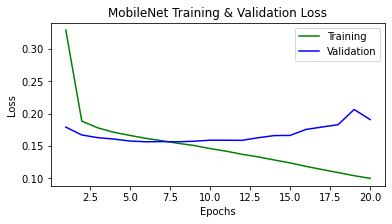

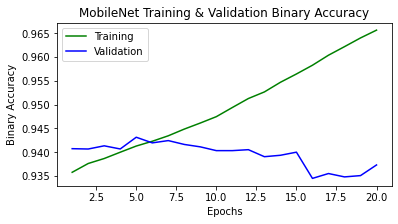

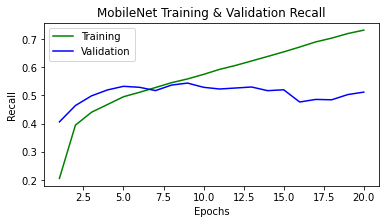

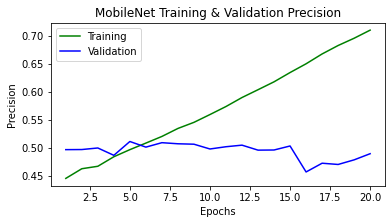

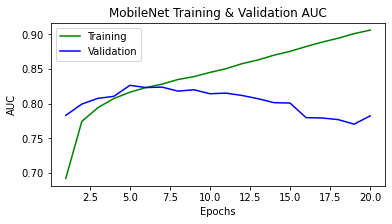

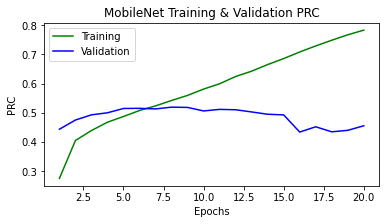

In [48]:
plt.figure(1, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['loss'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_loss'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(2, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['binary_accuracy'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_binary_accuracy'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Binary Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.show()

plt.figure(3, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['recall'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_recall'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(4, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['precision'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_precision'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

plt.figure(6, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['auc'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_auc'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

plt.figure(7, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['prc'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_prc'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation PRC')
plt.xlabel('Epochs')
plt.ylabel('PRC')
plt.legend()
plt.show()

In [49]:
# model.save_weights(f"./saved_weights_MLBCE/{MODEL_NAME}_{EPOCHS}_weights.h5")
evaluation = model.evaluate(test_generator)

319/319 [==============================] - 156s 489ms/step - loss: 0.1906 - tp: 2269.0000 - fp: 2019.0000 - tn: 69227.0000 - fn: 2820.0000 - binary_accuracy: 0.9366 - precision: 0.4845 - recall: 0.5052 - auc: 0.7796 - prc: 0.4545


In [105]:
model.save_weights(f"./mutually_excl_weights/{MODEL_NAME}_{EPOCHS}_weights.h5")

In [50]:
test_loss = evaluation[0]
TP = evaluation[1]
FP = evaluation[2]
TN = evaluation[3]
FN = evaluation[4]
binary_accuracy = evaluation[5] * 100
auc = evaluation[8] * 100
auc_pr = evaluation[9] * 100

specificity = (TN / (TN + FP)) * 100
recall = (TP / (TP + FN)) * 100
precision = (TP / (TP + FP)) * 100
f1_score = (2 * recall * precision) / (recall + precision)

print(f"Testing Loss: \t\t{test_loss}\n")
print(f"True Positives: \t{TP}\nFalse Positives: \t{FP}\nTrue Negatives: \t{TN}\nFalse Negatives: \t{FN}\n")
print(f"Binary Accuracy: \t{binary_accuracy}")
print(f"Average Recall: \t{recall}\nAverage Precision: \t{precision}\nF1-Score: \t\t{f1_score}\nAverage Specificity: \t{specificity}\n")
print(f"AUC: \t\t\t{auc}\nAUC-PR: \t\t{auc_pr}")

Testing Loss: 		0.19063474237918854

True Positives: 	2269.0
False Positives: 	2019.0
True Negatives: 	69227.0
False Negatives: 	2820.0

Binary Accuracy: 	93.6608076095581
Average Recall: 	44.58636274317155
Average Precision: 	52.91511194029851
F1-Score: 		48.39500906473286
Average Specificity: 	97.1661566965163

AUC: 			77.955561876297
AUC-PR: 		45.45338153839111


In [51]:
test_generator.reset()
predictions = model.predict(test_generator)

In [88]:
predicted_classes = np.argmax(predictions, axis=1)

In [89]:
len(predicted_classes)

5089

In [90]:
len(test_generator.labels)

5089

In [91]:
predicted_classes

array([ 8, 14, 10, ..., 10,  8, 10], dtype=int64)

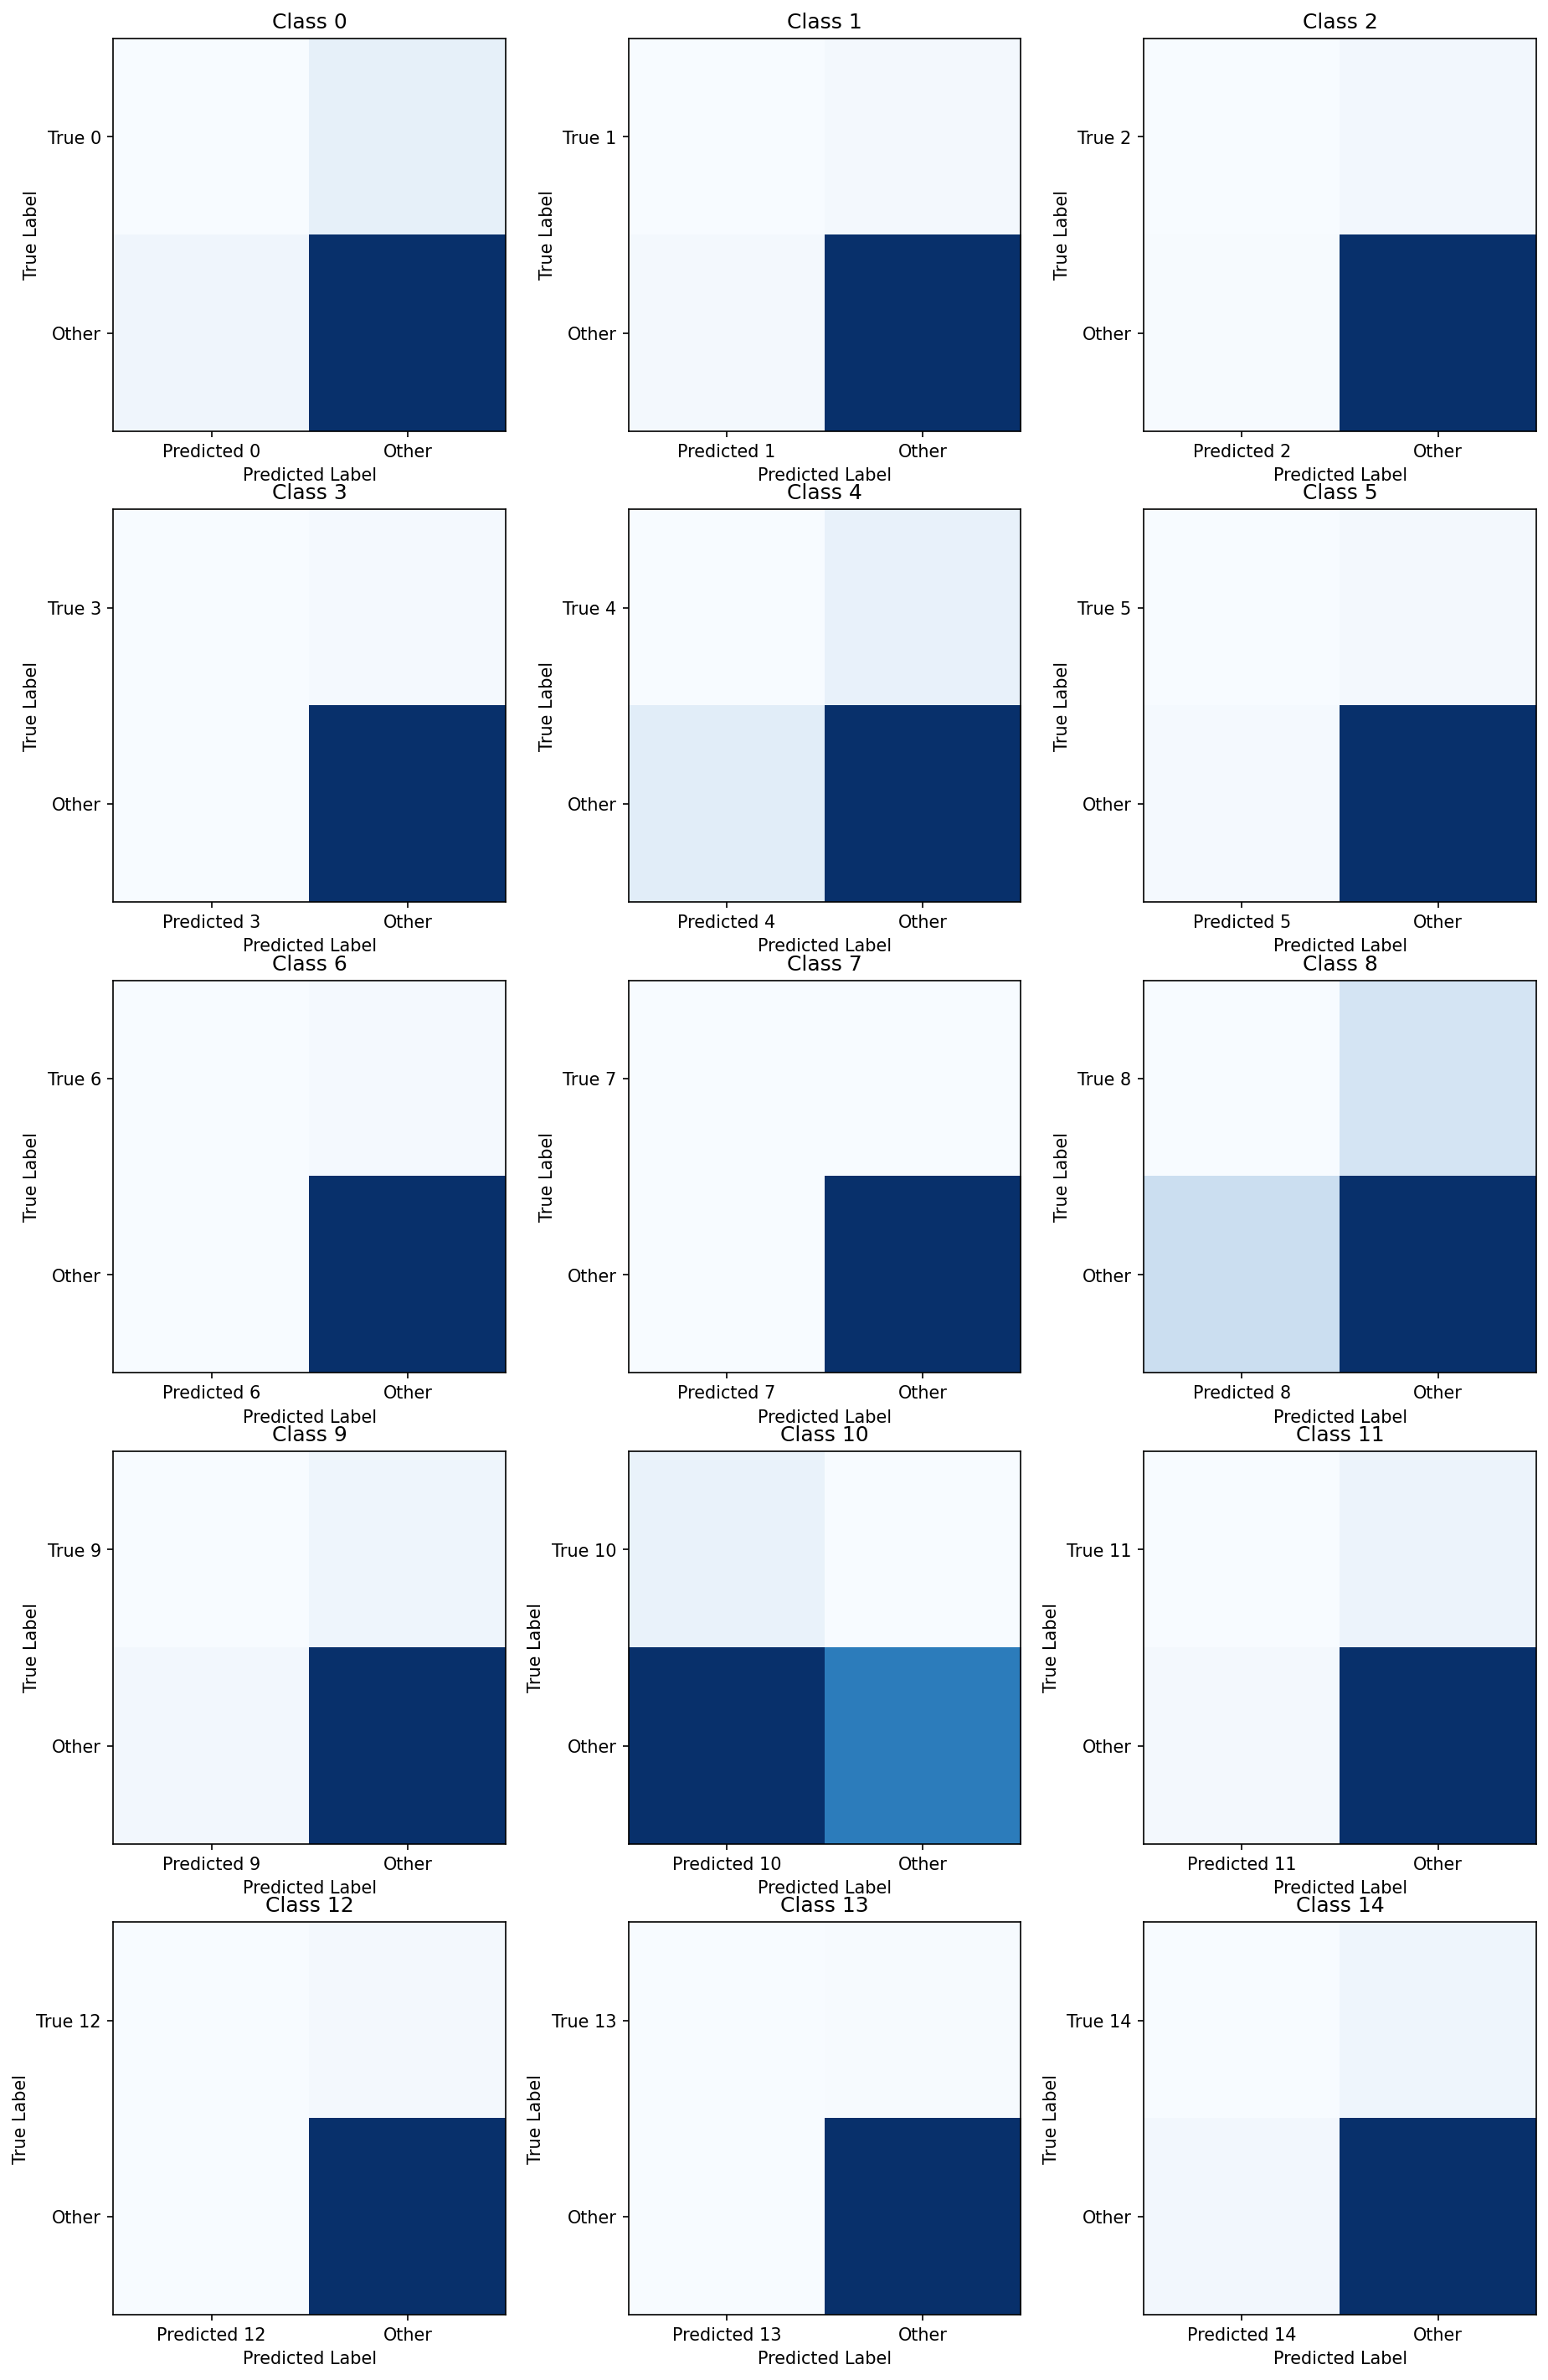

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# generate some sample data
y_true = test_generator.labels
y_pred = predicted_classes

# create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# create a figure with multiple subplots
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15,24))

# loop over each class and plot a separate confusion matrix
for i in range(15):
    # create a sub-matrix for the current class
    sub_cm = np.zeros((2,2))
    sub_cm[0,0] = cm[i,i]
    sub_cm[0,1] = np.sum(cm[i,:]) - sub_cm[0,0]
    sub_cm[1,0] = np.sum(cm[:,i]) - sub_cm[0,0]
    sub_cm[1,1] = np.sum(cm) - sub_cm[0,0] - sub_cm[0,1] - sub_cm[1,0]

    # plot the sub-matrix in the appropriate subplot
    row = i // 3
    col = i % 3
    axs[row, col].imshow(sub_cm, interpolation='nearest', cmap=plt.cm.Blues)
    axs[row, col].set_title('Class {}'.format(i))
    axs[row, col].set_xticks([0, 1])
    axs[row, col].set_yticks([0, 1])
    axs[row, col].set_xticklabels(['Predicted {}'.format(i), 'Other'])
    axs[row, col].set_yticklabels(['True {}'.format(i), 'Other'])
    axs[row, col].set_xlabel('Predicted Label')
    axs[row, col].set_ylabel('True Label')

plt.show()


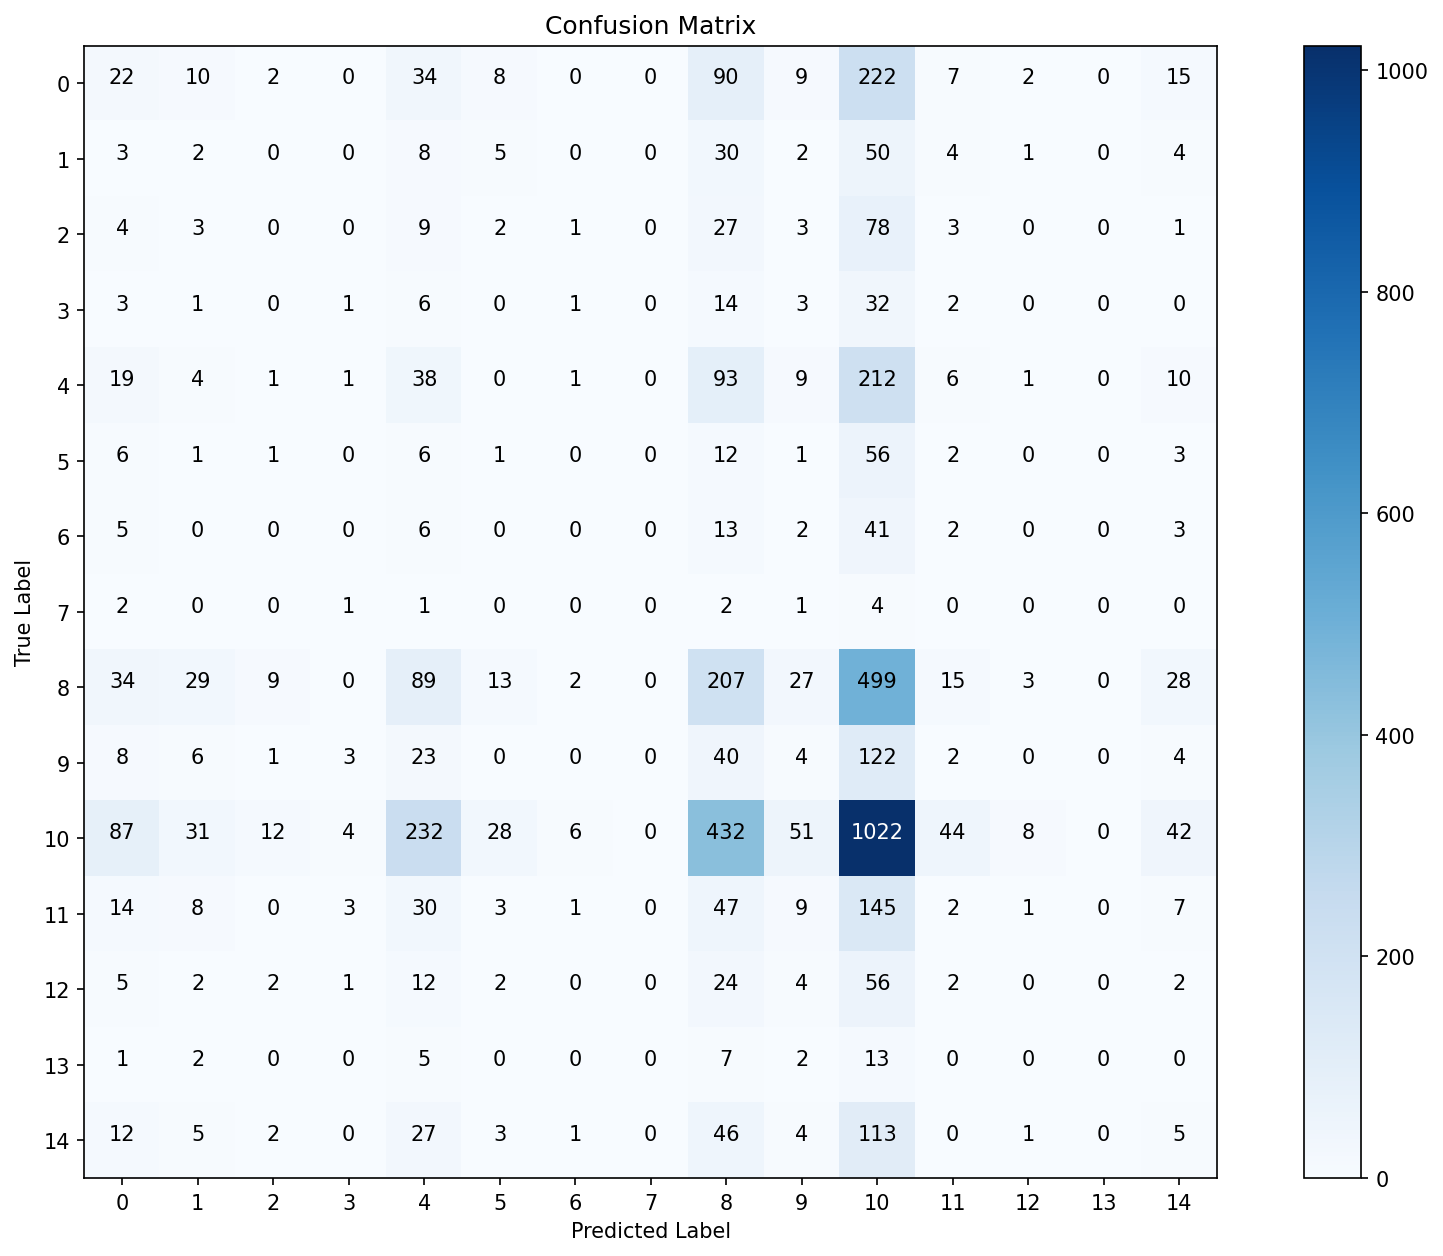

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# generate some sample data
y_true = test_generator.labels
y_pred = predicted_classes

# create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot the confusion matrix and print sample values
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(15)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# print sample values in the matrix for each class
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.show()


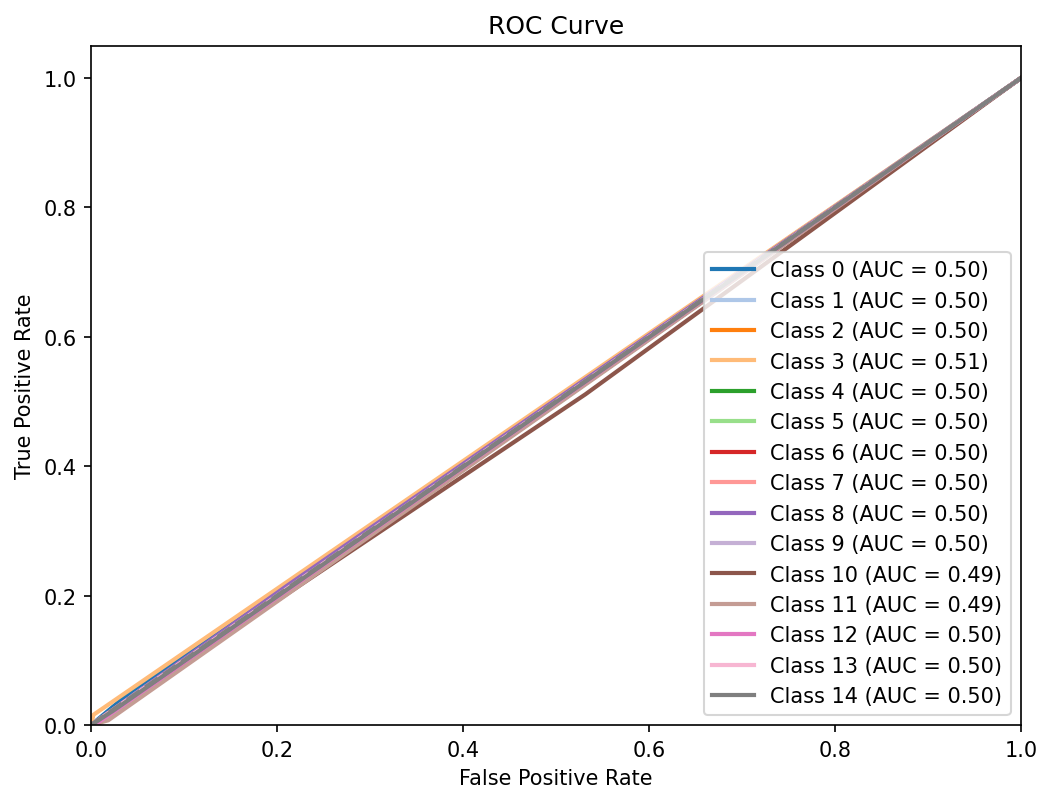

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# generate some sample data
y_true = test_generator.labels
y_pred = predicted_classes

# convert y_true to binary format
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

# reshape y_pred to 2-d array
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

# compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(15):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot the ROC curve for each class
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab20').colors
for i, color in zip(range(15), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

# plot the random curve
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# set plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [52]:
def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score
    
def print_results(beta, threshold, test_labels, prediction):
    accuracy = K.eval(binary_accuracy(K.variable(value = test_labels), K.variable(value = prediction)))
    precision = K.eval(precision_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    recall = K.eval(recall_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    f1_score = K.eval(fbeta_score_threshold(beta = beta, threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    print(f"BETA: {beta}, THRESHOLD: {threshold}")
    print (f"Binary Accuracy: \t{accuracy * 100} % \nRecall: \t\t{recall * 100} % \nPrecision: \t\t{precision * 100} % \nF1-Score: \t\t{f1_score * 100} %\n")

In [53]:
test_labels = []
for label in test_generator.labels:
    test_labels.append(label)

# # Results with F Score giving more weightage to Recall
# for threshold in THRESHOLDS:
#     print_results(beta = BETA_FOR_BIASED_RECALL, threshold = threshold, test_labels = test_labels, prediction = predictions)

# # Results with F Score giving more weightage to Precision
# for threshold in THRESHOLDS:
#     print_results(beta = BETA_FOR_BIASED_PRECISION, threshold = threshold, test_labels = test_labels, prediction = predictions)

# Results with F Score giving equal weightage to Recall and Precision
for threshold in THRESHOLDS:
    print_results(beta = BETA_WITH_NO_BIAS, threshold = threshold, test_labels = test_labels, prediction = predictions)

InvalidArgumentError: required broadcastable shapes [Op:Equal]

In [54]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize = 14):
    df_cm = pd.DataFrame(confusion_matrix, index = class_names, columns = class_names,)

    try:
        heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cbar = False, ax = axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right', fontsize = fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix - " + class_label)

In [55]:
threshold = 0.3
y_test = test_generator.labels
y_predicted = (predictions >= threshold).astype(int)
confusion_matrix = multilabel_confusion_matrix(y_test, y_predicted)

fig, ax = plt.subplots(3, 5, figsize=(22, 10))
for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrix, CLASS_LABELS):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [56]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 150

colors = cycle(['blue', 'red', 'green', 'black', 'purple', 'magenta', 'cyan', 'orange', 'teal', 'darkgreen'])
fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2

for i in range(len(CLASS_LABELS)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

avg_auc = 0
for auc_value in roc_auc.values():
    avg_auc += auc_value

print(f"[{MODEL_NAME} with {EPOCHS} Epochs] - Average AUC: {avg_auc / 15}")
    
for i, color in zip(range(len(CLASS_LABELS)), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = 2, label = '{0} (AUC = {1:0.2f})'''.format(CLASS_LABELS[i], roc_auc[i]))

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate', rotation = 0, labelpad = 50)
plt.title(f'ROC - {MODEL_NAME} with {EPOCHS} Epochs')
plt.legend(loc = "lower right")
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed